In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap = get_hashmap(path_to_module)
print(hashmap.keys())
dataset_name = 'emnist_balanced_digits'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)
batch_size = dataset_properties['batch_size'] = 1024
n_clusters = dataset_properties['n_clusters'] = 10
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)
print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['tcga', 'emnist_balanced_letters', 'emnist_mnist', 'emnist_balanced_digits', 'dermatology', 'ecoil', 'iris', 'rings', 'wine', 'australian', 'moons', 'squeezed_gauss', 'gauss_densities', 'pendigits', 'fashionmnist', '3dspheres', '20_newsgroups', 'coil20', 'cifar10', 'stl10', 'r15', 'r3'])
{'batch_size': 256, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}
Data_Shape is: 1
Batches Number is: 28


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 10
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 1e-4
sil_lambda = 0.01
entr_lambda = 0.01

kmeans_initialization = True
pretrain = False
is_MLP_AE = False

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
autoencoder = autoencoder.to(device)

In [8]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=10, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=False)
  )
  (decoder_

### Pretrain Autoencoder Model

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + "/Weigths/autoencoder_weights.pth"
    autoencoder.load_state_dict(torch.load(model_save_path))

In [10]:
# Initialize the clustering layer using k-means
if kmeans_initialization: autoencoder.kmeans_initialization(100)

ACC: 0.78 PUR: 0.79 NMI: 0.72 ARI: 0.65


In [11]:
"""
while True:
    # Code block to execute repeatedly
    autoencoder.trEpochs = 10
    autoencoder.train_autoencoder(silhouette_method = "default")
    visualization.makeExcel()
    #visualization.makePlot(useTSNE=False)
    #visualization.makePlot(useTSNE=True)
    visualization.plot_3D()

    # Check the condition to exit the loop
    if autoencoder.experimentName == "Experiment_400":
        break
"""
autoencoder.set_training_variables(n_epochs=200, lr=lr, sil_lambda=0.01, entr_lambda=0.01)

latent_data, labels, clustering = autoencoder.train_autoencoder()

cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 0.2981 Cl L: 0.2573 Entropy: 0.2300 SSil: 2.2707 SIL: 0.0000 ACC: 0.79 PUR: 0.79 NMI: 0.73 ARI: 0.66
Ep: 1 Rec L: 0.3016 Cl L: 0.2372 Entropy: 0.2048 SSil: 4.2777 SIL: 0.0000 ACC: 0.80 PUR: 0.80 NMI: 0.75 ARI: 0.68
Ep: 2 Rec L: 0.3050 Cl L: 0.2291 Entropy: 0.1911 SSil: 5.0851 SIL: 0.0000 ACC: 0.80 PUR: 0.81 NMI: 0.76 ARI: 0.69
Ep: 3 Rec L: 0.3089 Cl L: 0.2235 Entropy: 0.1812 SSil: 5.6496 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.76 ARI: 0.70
Ep: 4 Rec L: 0.3109 Cl L: 0.2180 Entropy: 0.1727 SSil: 6.1988 SIL: 0.0000 ACC: 0.81 PUR: 0.81 NMI: 0.77 ARI: 0.70
Ep: 5 Rec L: 0.3124 Cl L: 0.2137 Entropy: 0.1655 SSil: 6.6315 SIL: 0.0000 ACC: 0.81 PUR: 0.82 NMI: 0.77 ARI: 0.71
Ep: 6 Rec L: 0.3136 Cl L: 0.2103 Entropy: 0.1593 SSil: 6.9682 SIL: 0.0000 ACC: 0.81 PUR: 0.82 NMI: 0.78 ARI: 0.71
Ep: 7 Rec L: 0.3134 Cl L: 0.2069 Entropy: 0.1538 SSil: 7.3136 SIL: 0.0000 ACC: 0.81 PUR: 0.82 NMI: 0.78 ARI: 0.72
Ep: 8 Rec L: 0.3140 Cl L: 0.2035 Entropy: 0.1489 SSil: 7.6501 SIL: 0.0000 ACC: 0.82 PUR:

Ep: 71 Rec L: 0.3178 Cl L: 0.1429 Entropy: 0.0517 SSil: 13.7076 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 72 Rec L: 0.3160 Cl L: 0.1434 Entropy: 0.0517 SSil: 13.6574 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 73 Rec L: 0.3153 Cl L: 0.1419 Entropy: 0.0508 SSil: 13.8148 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 74 Rec L: 0.3191 Cl L: 0.1444 Entropy: 0.0503 SSil: 13.5568 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 75 Rec L: 0.3160 Cl L: 0.1418 Entropy: 0.0498 SSil: 13.8198 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 76 Rec L: 0.3156 Cl L: 0.1405 Entropy: 0.0493 SSil: 13.9547 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 77 Rec L: 0.3148 Cl L: 0.1406 Entropy: 0.0486 SSil: 13.9446 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 78 Rec L: 0.3155 Cl L: 0.1407 Entropy: 0.0481 SSil: 13.9273 SIL: 0.0000 ACC: 0.83 PUR: 0.84 NMI: 0.82 ARI: 0.76
Ep: 79 Rec L: 0.3179 Cl L: 0.1412 Entropy: 0.0474 SSil: 13.8847 SIL: 0.0

Ep: 142 Rec L: 0.3073 Cl L: 0.1253 Entropy: 0.0275 SSil: 15.4679 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 143 Rec L: 0.3091 Cl L: 0.1248 Entropy: 0.0273 SSil: 15.5165 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 144 Rec L: 0.3085 Cl L: 0.1255 Entropy: 0.0272 SSil: 15.4495 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 145 Rec L: 0.3076 Cl L: 0.1246 Entropy: 0.0268 SSil: 15.5381 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 146 Rec L: 0.3055 Cl L: 0.1248 Entropy: 0.0266 SSil: 15.5178 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 147 Rec L: 0.3084 Cl L: 0.1249 Entropy: 0.0266 SSil: 15.5102 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 148 Rec L: 0.3084 Cl L: 0.1250 Entropy: 0.0264 SSil: 15.4994 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 149 Rec L: 0.3038 Cl L: 0.1232 Entropy: 0.0261 SSil: 15.6751 SIL: 0.0000 ACC: 0.84 PUR: 0.84 NMI: 0.82 ARI: 0.77
Ep: 150 Rec L: 0.3065 Cl L: 0.1231 Entropy: 0.0259 SSil: 15.6913

In [12]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_1024_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01' already exists.


C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:22: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\General_Functions.py:26: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_1024_lr_0.0001_sil_lambda_0.01_entr_lambda_0.01/Experiments/No_TSNE' created successfully.


C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\Visualization.py:70: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(cluster_centers[:n_clusters, 0], cluster_centers[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


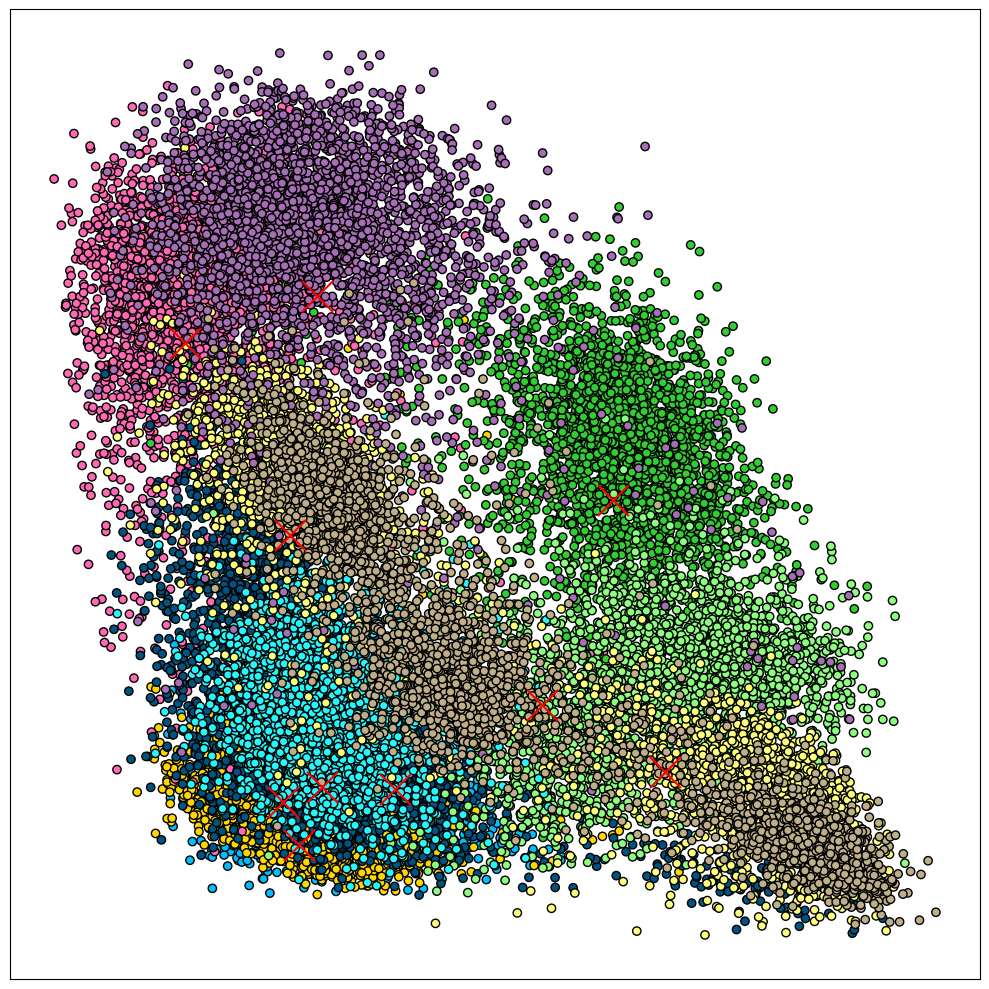

In [13]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28010 samples in 0.040s...
[t-SNE] Computed neighbors for 28010 samples in 1.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28010
[t-SNE] Computed conditional probabilities for sample 2000 / 28010
[t-SNE] Computed conditional probabilities for sample 3000 / 28010
[t-SNE] Computed conditional probabilities for sample 4000 / 28010
[t-SNE] Computed conditional probabilities for sample 5000 / 28010
[t-SNE] Computed conditional probabilities for sample 6000 / 28010
[t-SNE] Computed conditional probabilities for sample 7000 / 28010
[t-SNE] Computed conditional probabilities for sample 8000 / 28010
[t-SNE] Computed conditional probabilities for sample 9000 / 28010
[t-SNE] Computed conditional probabilities for sample 10000 / 28010
[t-SNE] Computed conditional probabilities for sample 11000 / 28010
[t-SNE] Computed conditional probabilities for sample 12000 / 28010
[t-SNE] Computed conditional probabilities for sam

C:\Users\PAPASOFT INC\Documents\GitHub\Soft-Silhouette\Visualization.py:43: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_embeddings[:n_clusters, 0], tsne_embeddings[:n_clusters, 1], c='red', marker='x', s=500, edgecolors='black', label='Cluster Centers')


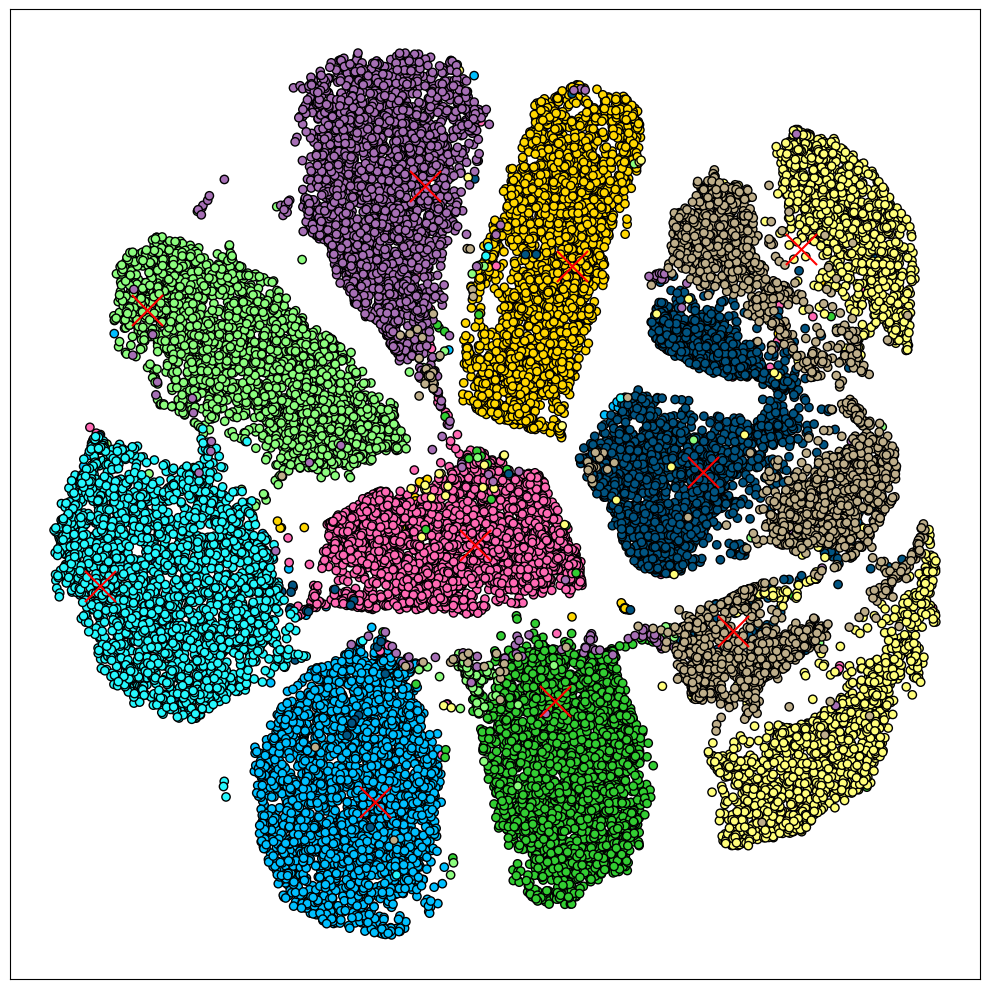

In [14]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [15]:
cluster_centers

array([[-0.5683203 , -1.1377729 ,  1.226471  ,  1.6059737 , -1.0100133 ,
         1.6012099 ,  1.459703  ,  0.9762102 ,  0.6023554 , -0.5342326 ],
       [-0.6577852 , -0.89471054, -1.8395342 , -1.2027935 ,  1.0281924 ,
         0.35499042, -1.0695435 ,  0.14598717, -0.41780853,  0.28467008],
       [ 1.4902114 , -0.729107  ,  0.6597355 ,  1.0235051 ,  0.03873721,
         0.20649222, -1.1227883 ,  0.63406205, -1.4249734 ,  1.0985883 ],
       [-1.2127023 ,  1.6866155 ,  0.4553362 , -0.39782956, -1.4159762 ,
         0.77545893, -1.4399126 , -0.35173053, -0.50586295, -0.39308995],
       [-0.4394574 , -0.8090257 , -0.63163054, -0.6646027 , -0.87538517,
         1.1232244 ,  1.0059853 , -1.6921382 ,  1.2323523 , -1.4037709 ],
       [-0.0279161 , -0.8236198 ,  0.946019  ,  0.2348318 ,  0.1249807 ,
        -0.39505437,  1.2016107 , -1.5018443 , -1.4297673 ,  1.5377578 ],
       [ 1.1983426 ,  0.80269855, -0.65078586,  1.3998209 , -1.1022087 ,
        -0.8126388 , -0.36153775,  0.80180407

In [16]:
clustering[0:100]

array([6, 2, 5, 7, 7, 0, 1, 4, 2, 0, 5, 9, 8, 0, 2, 2, 6, 8, 3, 7, 2, 5,
       1, 3, 3, 7, 4, 9, 8, 8, 1, 7, 8, 6, 2, 1, 0, 8, 1, 3, 6, 2, 3, 3,
       0, 1, 4, 8, 8, 9, 0, 0, 0, 3, 2, 2, 0, 4, 2, 8, 9, 6, 7, 2, 5, 7,
       8, 7, 1, 9, 2, 7, 3, 8, 9, 4, 4, 1, 7, 1, 6, 1, 1, 8, 7, 3, 5, 9,
       6, 1, 7, 4, 1, 2, 7, 0, 2, 3, 1, 4], dtype=int64)

In [17]:
latent_data

array([[ 2.3976083 ,  0.09301882, -0.7673385 , ...,  1.2672111 ,
         1.0075905 , -1.5833386 ],
       [ 1.8423104 , -1.0400311 ,  0.8614654 , ...,  0.38554958,
        -1.7194061 ,  1.358034  ],
       [-0.5157173 , -0.88175946,  0.9305411 , ..., -2.6291492 ,
        -1.0389898 ,  1.4033465 ],
       ...,
       [ 0.94939774, -0.76108474,  1.292928  , ...,  1.4655639 ,
        -2.0244167 ,  1.6430572 ],
       [-1.0545845 , -0.9479698 , -2.3399317 , ...,  0.6725637 ,
        -0.37066248,  0.45751724],
       [-0.26822987,  2.0011394 ,  0.53427   , ..., -1.0795215 ,
        -0.36290187, -1.1983733 ]], dtype=float32)